In [68]:
%env CUDA_VISIBLE_DEVICES=-1
%load_ext autoreload
%autoreload 2
from plot_utils import *
import sys
import os
from PIL import Image
import itertools

env: CUDA_VISIBLE_DEVICES=-1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
datasets = ["bicycle","bonsai"]
eval_paths = {}
for exp in os.listdir("../output"):
        eval_paths[exp] = {"orig" : {}, "mini_s" : {}, "c3dgs" : {}}

        for ds in datasets:
            p = os.path.join("../output",exp,ds,"test","ours_30000")
            if os.path.exists(p):
                eval_paths[exp]["orig"][ds] = p
            
            p_mini = os.path.join("../output",exp,"mini_s",ds,"test","ours_30000")
            if os.path.exists(p_mini):
                eval_paths[exp]["mini_s"][ds] = p_mini

            p_c3dgs = os.path.join("../output",exp,"c3dgs",ds,"test","ours_35000")
            if os.path.exists(p_mini):
                eval_paths[exp]["c3dgs"][ds] = p_c3dgs

                
stats = load_stats(eval_paths)
normalized_stats,min_max = normalize_stats(stats,datasets)

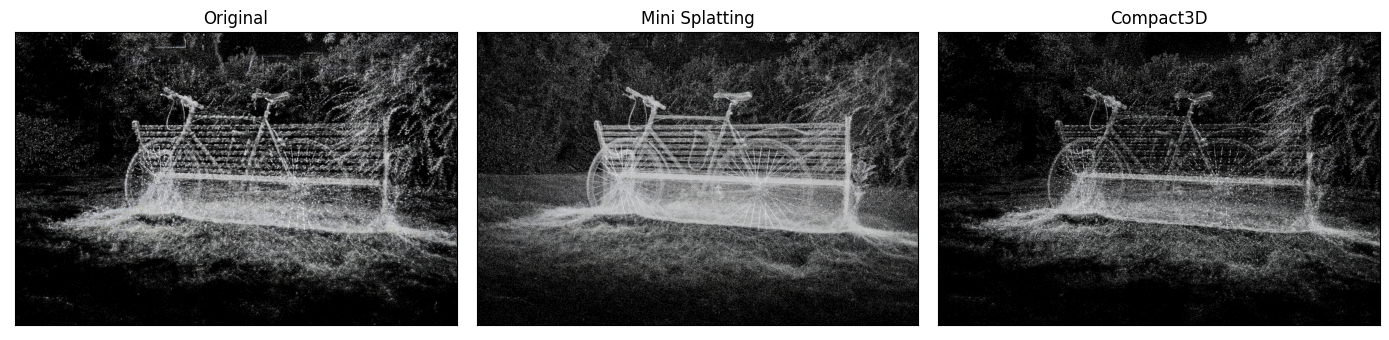

In [70]:
# Plot the density (where are gaussians where not) for a specific image from the bicycle dataset for Original,Mini Splatting and Compact3D
fig,axs = plt.subplots(1,3)
remove_ticks = lambda *axs : [(ax.set_xticks([]),ax.set_xticklabels([]),ax.set_yticks([]),ax.set_yticklabels([])) for ax in axs]
axs[0].imshow(Image.open(os.path.join(eval_paths["orig"]["orig"]["bicycle"],"density","00000.png")))
axs[1].imshow(Image.open(os.path.join(eval_paths["mini"]["orig"]["bicycle"],"density","00000.png")))
axs[2].imshow(Image.open(os.path.join(eval_paths["compact3d"]["orig"]["bicycle"],"density","00000.png")))
remove_ticks(axs[0],axs[1],axs[2])

axs[0].set_title("Original")
axs[1].set_title("Mini Splatting")
axs[2].set_title("Compact3D")


fig.set_size_inches(14,16)
fig.tight_layout()

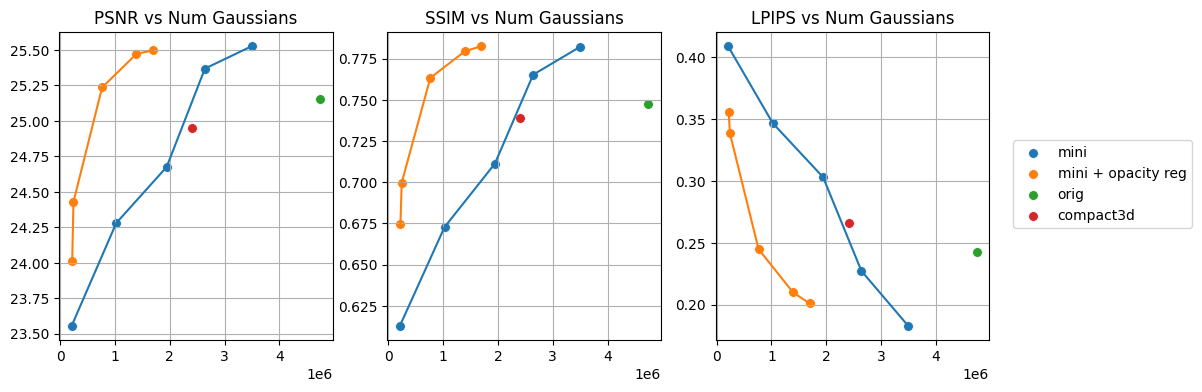

In [71]:
# Plot (PSNT,SSIM,LPIPS) vs num Gaussians for the bicycle dataset
fig,axs = plt.subplots(1,3)
colors = list(sns.color_palette())
for x,y in enumerate(["psnr","ssim","lpips"]):
    sns.scatterplot(x=[stats[f"mini_{i}"]["orig"]["bicycle"]["num_gaussians"] for i in [1,3,5,7,8]],y=[stats[f"mini_{i}"]["orig"]["bicycle"][y] for i in [1,3,5,7,8]],color=colors[0],ax=axs[x],s=50,label="mini")
    sns.lineplot(x=[stats[f"mini_{i}"]["orig"]["bicycle"]["num_gaussians"] for i in [1,3,5,7,8]],y=[stats[f"mini_{i}"]["orig"]["bicycle"][y] for i in [1,3,5,7,8]],color=colors[0],ax=axs[x])

    sns.scatterplot(x=[stats[f"mini_opacity_{i}"]["orig"]["bicycle"]["num_gaussians"] for i in [1,2,5,6,7]],y=[stats[f"mini_opacity_{i}"]["orig"]["bicycle"][y] for i in [1,2,5,6,7]],color=colors[1],ax=axs[x],s=50,label="mini + opacity reg")
    sns.lineplot(x=[stats[f"mini_opacity_{i}"]["orig"]["bicycle"]["num_gaussians"] for i in [1,2,5,6,7]],y=[stats[f"mini_opacity_{i}"]["orig"]["bicycle"][y] for i in [1,2,5,6,7]],color=colors[1],ax=axs[x])
    
    sns.scatterplot(x=[stats[f"orig"]["orig"]["bicycle"]["num_gaussians"]],y=[stats[f"orig"]["orig"]["bicycle"][y]],ax=axs[x],s=50,color=colors[2],label="orig")
    sns.scatterplot(x=[stats[f"compact3d"]["orig"]["bicycle"]["num_gaussians"]],y=[stats[f"compact3d"]["orig"]["bicycle"][y]],ax=axs[x],s=50,color=colors[3],label="compact3d")
    #sns.scatterplot(x=[stats[f"compact3d_noscale"]["orig"]["bicycle"]["num_gaussians"]],y=[stats[f"compact3d_noscale"]["orig"]["bicycle"][y]],ax=axs[x],s=50,color=colors[3],label="compact3d noscale")
    #sns.scatterplot(x=[stats[f"orig_opacity"]["orig"]["bicycle"]["num_gaussians"]],y=[stats[f"orig_opacity"]["orig"]["bicycle"][y]],ax=axs[x],s=50,color=colors[4],label="orig + opacity reg")
    #sns.scatterplot(x=[stats[f"mini_compact3d"]["orig"]["bicycle"]["num_gaussians"]],y=[stats[f"mini_compact3d"]["orig"]["bicycle"][y]],ax=axs[x],s=50,color=colors[5],label="mini + compact3d")
    axs[x].grid(True)
    axs[x].get_legend().remove()

axs[0].set_title("PSNR vs Num Gaussians")
axs[1].set_title("SSIM vs Num Gaussians")
axs[2].set_title("LPIPS vs Num Gaussians")

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles,labels,loc='center right',ncol=1,frameon=True,bbox_to_anchor=(1.075, 0.5),)

fig.set_size_inches(12,4)

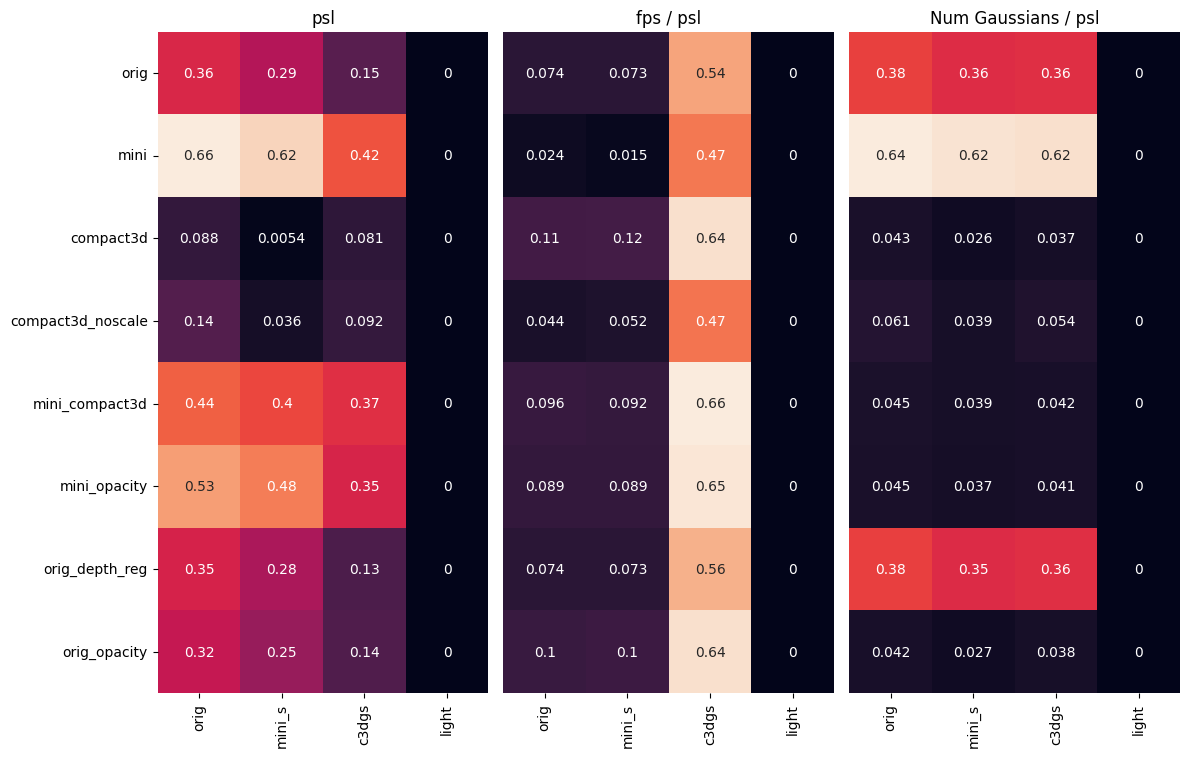

In [ ]:
exps = ["orig","mini","compact3d","compact3d_noscale","mini_compact3d","mini_opacity","orig_depth_reg","orig_opacity"]
compressions = ["orig","mini_s","c3dgs","light"]

table_stats = copy.deepcopy(stats)
table_stats = {key : {comp_key : comp_val for comp_key,comp_val in val.items() if comp_key in compressions} for key,val in table_stats.items() if key in exps}
table_stats_normalized,table_min_max = normalize_stats(table_stats,datasets)
merge_psnr_ssim_lpips(table_stats_normalized)

fig,axs = plt.subplots(1,3,sharex=True)
axs = axs[None,:]
for x,y in enumerate(["psl","fps","num_gaussians"]):
    data = np.zeros((len(exps),4))
    ratio = np.zeros((len(exps),4))
    norm = np.ones_like(data)
    for dx,exp in enumerate(exps):
        for dy,compression in enumerate(compressions):
            for ds in datasets:
                if compression in table_stats_normalized[exp].keys():
                    if ds in table_stats_normalized[exp][compression].keys():
                        if y in table_stats_normalized[exp][compression][ds].keys() and "psl" in table_stats_normalized[exp][compression][ds].keys():
                            data[dx,dy] += table_stats_normalized[exp][compression][ds][y]
                            ratio[dx,dy] += (table_stats_normalized[exp][compression][ds][y]+1)/(table_stats_normalized[exp][compression][ds]["psl"]+1)
                            norm[dx,dy] += 1
    #ratio = (ratio-ratio.min())/(ratio.max()-ratio.min())
    data = data/norm
    ratio = ratio/norm

    #if y == "psl":
    #    pass
    #else:
    #    data = ratio
    if x == 0:
        sns.heatmap(data,ax=axs[0][x],yticklabels=exps,xticklabels=compressions,cbar=False,annot=True,square=True)
    elif x == 1:
        sns.heatmap(data,ax=axs[0][x],yticklabels=[],xticklabels=compressions,cbar=False,annot=True,square=True)
        #sns.heatmap(ratio,ax=axs[1][x],yticklabels=exps,xticklabels=compressions,cbar=False,annot=True,square=True)
    else:
        sns.heatmap(data,ax=axs[0][x],yticklabels=[],xticklabels=compressions,cbar=False,annot=True,square=True)
        #sns.heatmap(ratio,ax=axs[1][x],yticklabels=[],xticklabels=compressions,cbar=False,annot=True,square=True)


axs[0][0].set_title("psl")
axs[0][1].set_title("fps")
axs[0][2].set_title("Num Gaussians")

fig.set_size_inches(12,12)
fig.tight_layout()

In [73]:
table_min_max

{'bicycle': {'l1_loss': {'min': 0.0369694510102272,
   'max': 0.04098195545375347},
  'psnr': {'min': 24.49499008178711, 'max': 25.551157608032227},
  'ssim': {'min': 0.7278256416320801, 'max': 0.7856951355934143},
  'lpips': {'min': 0.18030184507369995, 'max': 0.27425825595855713},
  'fps': {'min': 55.50205673924113, 'max': 362.64219935753056},
  'num_gaussians': {'min': 2075189.0, 'max': 4746115.0}},
 'bonsai': {'l1_loss': {'min': 0.014116841896965698,
   'max': 0.016841644471561588},
  'psnr': {'min': 31.24134940070075, 'max': 32.575051024153424},
  'ssim': {'min': 0.9380464553833008, 'max': 0.9534109830856323},
  'lpips': {'min': 0.15041252970695496, 'max': 0.20194636285305023},
  'fps': {'min': 72.71883147653276, 'max': 428.1527979302993},
  'num_gaussians': {'min': 601081.0, 'max': 3673366.0}}}